In [67]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# K-Means Clustering: A Larger Example

Now that we understand the k-means clustering algorithm, let's try an example with more features and use cross-validation to choose k. We will also show how you can (and should!) run the algorithm multiple times with different initial centroids because, as we saw in the animations from the previous section, the initialization can have an effect on the final clustering.

## Clustering Countries

For this example, we will use a dataset[^*] with information about countries across the world. It includes demographic, economic, environmental, and socio-economic information from 2023. This data and more information about it can be found [here](https://doi.org/10.34740/KAGGLE/DSV/6101670). The first few lines are shown below.

In [68]:
countries = pd.read_csv("../../data/world-data-2023.csv")
countries.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


We want to see if we can cluster countries based on their characteristics. First, we need to do some cleaning. I don't want to include `Abbreviation`, `Calling Code`, `Capital/Major City`, `Largest city`, `Latitude`, or `Longitude` in my analysis because they uniquely identify a given country. I also see some variables that are numeric with percentage signs, dollar signs, and commas. These are characters which indicate that the variable is a string, but I would like them to be floats instead so that Python knows they have a numerical meaning.

The code used for this cleaning is hidden for brevity, but the resulting, clean dataframe is shown below.

In [69]:
countries_clean = countries.drop(columns = ['Abbreviation', 'Calling Code', 'Capital/Major City', 'Largest city', 'Latitude', 'Longitude'])

def str_to_num(my_input):
    '''Takes in a number in string format and removes commas 
    and percentage signs before returning it as a float or int
    
    If the string is not a number or input is not a string, 
    returns the input'''


    if type(my_input) is str:

        cleaned_input = my_input.strip() #strip trailing whitespace
        cleaned_input = cleaned_input.removeprefix("$").removesuffix("%") #remove these characters if they are present
        
        if cleaned_input.isdigit():
            return int(cleaned_input)
        elif ("." in cleaned_input) and (cleaned_input.replace(".","").replace("-","").isdigit()): #is the only non-digit character a "."
            return float(cleaned_input)
        elif ("," in cleaned_input) and (cleaned_input.replace(",","").replace("-","").isdigit()): #is the only non-digit character a ","
            return int(cleaned_input.replace(",",""))
        elif ("." in cleaned_input) and ("," in cleaned_input) and (cleaned_input.replace(".","").replace(",","").replace("-","").isdigit()): #contains 2 non-digit characters "," and "."
            return float(cleaned_input.replace(",",""))
        else:
            return my_input
    else:
        return my_input
    
countries_clean = countries_clean.map(str_to_num) #apply this function to every cell in the dataframe
countries_clean = countries_clean.drop(columns=["Minimum wage"]).dropna() #remove rows with any missing values, also remove the `Minimum wage` column as it has 45 missing values
countries_clean.head()

,Country,Density\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Currency-Code,...,Maternal mortality ratio,Official language,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population
0,Afghanistan,60,58.1,652230.0,323000.0,32.49,8672.0,149.90,2.3,AFN,...,638.0,Pashto,78.4,0.28,38041754.0,48.9,9.3,71.4,11.12,9797273.0
1,Albania,105,43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,ALL,...,15.0,Albanian,56.9,1.20,2854191.0,55.7,18.6,36.6,12.33,1747593.0
2,Algeria,18,17.4,2381741.0,317000.0,24.28,150006.0,151.36,2.0,DZD,...,112.0,Arabic,28.1,1.72,43053054.0,41.2,37.2,66.1,11.70,31510100.0
4,Angola,26,47.5,1246700.0,117000.0,40.73,34693.0,261.73,17.1,AOA,...,241.0,Portuguese,33.4,0.21,31825295.0,77.5,9.2,49.1,6.89,21061025.0
6,Argentina,17,54.3,2780400.0,105000.0,17.02,201348.0,232.75,53.5,ARS,...,39.0,Spanish,17.6,3.96,44938712.0,61.3,10.1,106.3,9.79,41339571.0


### Using `sklearn`

In the previous section, we wrote our own functions to implement the k-means algorithm. This is a useful exercise to make sure we understand how the algorithm works, but there are libraries with optimized functions built to do these kinds of common analyses. The library `sklearn` is a popular machine learning library and has built in functions to do k-means clustering that are much faster than the functions we wrote. It is useful to know how to use these functions as well. First, you may need to install `sklearn`.

Before, we can cluster the data, we need to do some preprocessing. In the past, we have used our own functions to standardize and dummycode variables, but here we will show how to use functions from `sklearn`. First, w will need to import some functions from `sklearn.preprocessing`.

In [70]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [71]:
country_names = countries_clean['Country']
num_columns = countries_clean.drop(columns=['Country', 'Currency-Code', 'Official language'])
cat_columns = countries_clean[['Currency-Code', 'Official language']]

In [72]:
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
cat_dummies = encoder.fit_transform(cat_columns)

In [73]:
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_columns)

In [74]:
countries_proc = np.concatenate((num_scaled,cat_dummies), axis = 1)

 and then import the `KMeans` function from `sklearn.cluster`.

In [75]:
from sklearn.cluster import KMeans

The `KMeans` function takes in the number of clusters, k, as `n_clusters`, the number of times the algorithm should be run with different initial centroids as `n_init`, and a random seed (as explained in [Section 10.3](../../10/3/sampling.ipynb)) as `random_state`. It also takes in a maximum number of iterations and a tolerance as `max_iter` with default 300 and `tol` with default $10^{-4}$ respectively. For more information about the function, see the `scikit-learn` documentation ![[here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)].

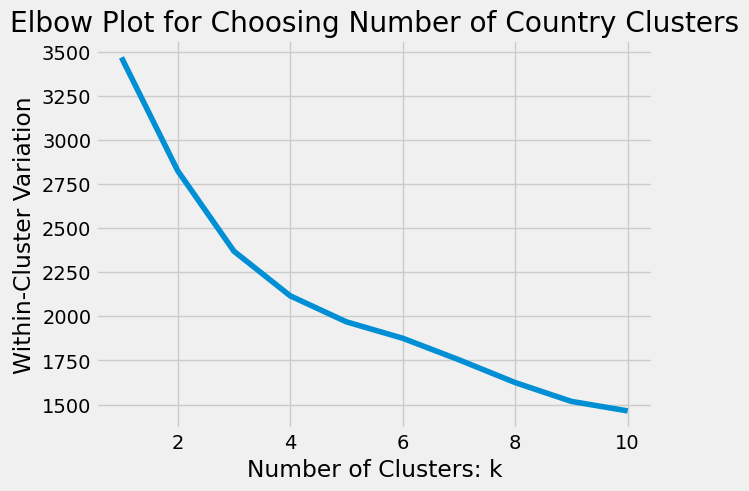

In [76]:
sse = []
for k in range(1, 11):
   kmeans = KMeans(n_clusters=k, n_init=10)
   kmeans.fit(countries_proc)
   sse.append(kmeans.inertia_)

plt.plot(range(1, 11),sse)
plt.xlabel("Number of Clusters: k")
plt.ylabel("Within-Cluster Variation")
plt.title('Elbow Plot for Choosing Number of Country Clusters');

The elbow of this plot looks to be around k = 4. So we will choose 4 clusters for our data.

In [80]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(countries_proc)

kmeans.labels_

array([1, 3, 3, 1, 3, 3, 0, 3, 0, 3, 0, 0, 0, 1, 3, 0, 0, 1, 1, 1, 3, 1,
       0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 3, 3, 0, 1, 3, 0, 0, 1, 1, 0, 0,
       1, 0, 3, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0, 0, 0, 3, 3, 1, 0, 3, 1, 0,
       3, 0, 0, 1, 1, 0, 1, 0, 0, 3, 3, 3, 1, 1, 1, 0, 3, 1, 1, 0, 0, 1,
       1, 3, 0, 3, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 0, 0, 0, 3, 0, 0, 3, 1,
       0, 0, 0, 3, 3, 1, 0, 1, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0, 1],
      dtype=int32)

In [81]:
country_names[kmeans.labels_ == 0]

9                   Austria
12                  Bahrain
14                 Barbados
16                  Belgium
17                   Belize
23                   Brazil
25                 Bulgaria
32                   Canada
35                    Chile
37                 Colombia
40               Costa Rica
41                  Croatia
43                   Cyprus
44           Czech Republic
46                  Denmark
55                  Estonia
59                  Finland
60                   France
63                  Georgia
64                  Germany
66                   Greece
75                  Hungary
76                  Iceland
81      Republic of Ireland
82                   Israel
83                    Italy
84                  Jamaica
90                   Kuwait
93                   Latvia
99                Lithuania
100              Luxembourg
103                Malaysia
106                   Malta
109               Mauritius
123             New Zealand
129                 

In [82]:
country_names[kmeans.labels_ == 1]

0                           Afghanistan
4                                Angola
18                                Benin
26                         Burkina Faso
27                              Burundi
28                          Ivory Coast
31                             Cameroon
39                Republic of the Congo
45     Democratic Republic of the Congo
57                             Ethiopia
61                                Gabon
62                           The Gambia
65                                Ghana
69                               Guinea
88                                Kenya
92                                 Laos
101                          Madagascar
102                              Malawi
105                                Mali
117                          Mozambique
118                             Myanmar
121                               Nepal
125                               Niger
126                             Nigeria
131                            Pakistan


In [83]:
country_names[kmeans.labels_ == 2]

36    China
77    India
Name: Country, dtype: object

In [84]:
country_names[kmeans.labels_ == 3]

1                 Albania
2                 Algeria
6               Argentina
7                 Armenia
10             Azerbaijan
13             Bangladesh
22               Botswana
29             Cape Verde
49     Dominican Republic
51                  Egypt
58                   Fiji
68              Guatemala
74               Honduras
78              Indonesia
79                   Iran
80                   Iraq
86                 Jordan
87             Kazakhstan
91             Kyrgyzstan
94                Lebanon
112               Moldova
114              Mongolia
116               Morocco
124             Nicaragua
136              Paraguay
138           Philippines
151          Saudi Arabia
161          South Africa
165             Sri Lanka
170                 Syria
171            Tajikistan
178               Tunisia
179                Turkey
183               Ukraine
Name: Country, dtype: object

In [92]:
import plotly.express as px

dat = pd.DataFrame({'country_names': country_names, 'cluster': np.array([str(lab) for lab in kmeans.labels_])})

fig = px.choropleth(dat, locations="country_names",
                    locationmode='country names',
                    color="cluster", 
                    hover_name="country_names",
                    category_orders={"cluster":["0","1","2","3"]})
fig.update_layout(legend_title_text='Cluster')

fig.show()

## Disadvantages of `K-Means` Clustering

As we discussed previously, k-means clustering has several disadvantages. It does not always converge to a solution that provides the global minimum within-cluster variability. Because of this, it can also give differing solutions depending on the initial starting points. In addition, the k-means algorithm requires the user to specify the number of clusters, which may not always be obvious, especially for data with high dimensionality. In the next section, we will discuss another clustering method that does not require you to specify a number of clusters: hierarchical clustering.

[^*]: Nidula Elgiriyewithana. (2023). Global Country Information Dataset 2023 [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/6101670